    Copyright (C) 2015 Jingkun Gao (jingkun@cmu.edu)
    
    This file is part of PLAID code repo.
    
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>

# Initial Expoloreation of PLAID dataset

In this IPython Notebook, I will show how to parse the data from CSV files and get the corresponding meta data from JSON files. Meanwhile, I will plot a few appliance intances from each type.

<span style="color:red">Please make sure Python3 and other necessary packages (using pip3 to install <b>*ipython, jinja2, jsonschema, matplotlib, numpy, scipy, pyzmq, pygments, tornado, scikit-learn*</b>) are installed,</span>

## Load Dataset

We start from looking at the files under the path of the Dataset. The foler <b>CSV</b> contains csv files represnting all the appliance data, where each file have two columns, the first for current and the second for voltage. The name of the file is an integer starting from 1 reprsenting the instance id. All the associated meta data information can be found in <b>meta1.json</b>.

<b>meta1.json</b> contains the meta data collected in July, 2013, where only the appliance type information is recoreded. For some appliances with multiple states, the transition of different states are also recorded.

In [1]:
Data_path = 'PLAID/'
%ls $Data_path

CSV/  meta1.json


The initial thought is to load all csv files into the memory. However, we noticed that all csv files are too huge to be loaded into the memory, so we wrote a function to read data from the CSV path given a list of instance ids (which are the file names).

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

csv_path = Data_path + 'CSV/'
csv_files = os.listdir(csv_path)


In [3]:
import subprocess

def read_data_given_id(path,ids,progress=False,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress:
                print('%d/%d is being read...'%(i,n))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',delimiter=',',\
                                         names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(offset)),path+str(ist_id)+'.csv'],\
                                   stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',names='current,voltage',\
                                             dtype=(float,float))
        return data

Then, we use JSON package to load meta data.

In [4]:
import json

with open(Data_path + 'meta1.json') as data_file:    
    meta1 = json.load(data_file)


meta = [meta1]

In [5]:
meta1[0]

{'id': '1',
 'meta': {'appliance': {'brand': '',
   'current': '',
   'manufacture_year': '',
   'model_number': '',
   'notes': '',
   'voltage': '',
   'wattage': ''},
  'header': {'collection_time': 'July, 2013',
   'notes': 'some instances are not well calibrated, meta data are not complete',
   'sampling_frequency': '30000Hz'},
  'instances': {'length': '2.00s', 'status': 'off-on'},
  'location': 'house1',
  'type': 'Compact Fluorescent Lamp'}}

We define two functions to parse meta data stored in JSON format.

In [6]:
def clean_meta(ist):
    '''remove '' elements in Meta Data ''' 
    clean_ist = ist.copy()
    for k,v in ist.items():
#         if 
        if len(v) == 0:
            del clean_ist[k]
    return clean_ist
                
def parse_meta(meta):
    '''parse meta data for easy access'''
    M = {}
    for m in meta:
        for app in m:
            M[int(app['id'])] = clean_meta(app['meta'])
    return M
            
    

In [7]:
Meta = parse_meta(meta)

We can then check the associated meta data given instance id (an interger starting from 1). One examples can be seen below.

In [8]:
Meta[1000]

{'appliance': {'brand': '',
  'current': '',
  'manufacture_year': '',
  'model_number': '',
  'notes': '',
  'voltage': '',
  'wattage': ''},
 'header': {'collection_time': 'July, 2013',
  'notes': 'some instances are not well calibrated, meta data are not complete',
  'sampling_frequency': '30000Hz'},
 'instances': {'length': '2.00s', 'status': 'off-on'},
 'location': 'house51',
 'type': 'Laptop'}

We extracted type information for all instances by checking the key "type".

In [9]:
# applinace types of all instances
Types = [x['type'] for x in Meta.values()]
# unique appliance types
Unq_type = list(set(Types)) 
Unq_type.sort()
print(Unq_type)

# appliances
Apps = [x['meta']['type'] for x in meta1]

['Air Conditioner', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washing Machine']


In [10]:
print('number of total instances: %d' % len(Types))
print('number of unique appliances: %d' % len(Apps))
print('number of unique appliance types: %d' % len(Unq_type))

number of total instances: 1074
number of unique appliances: 1074
number of unique appliance types: 11


## Plot Instances from PLAID

In this section, we will explore instances from differnt appliance types.

At first, we would like to see the statistics of each appliances types.

In [11]:
print('%25s\t%8s' % ('Appliance Type','# instances'))
for t in Unq_type:
    t_ids = [i for i,j in enumerate(Types) if j == t]
    print('%25s\t%10d' % (t,len(t_ids)))
    

           Appliance Type	# instances
          Air Conditioner	        66
 Compact Fluorescent Lamp	       175
                      Fan	       115
                   Fridge	        38
                Hairdryer	       156
                   Heater	        35
  Incandescent Light Bulb	       114
                   Laptop	       172
                Microwave	       139
                   Vacuum	        38
          Washing Machine	        26


Then, we will randomly draw 5 instances from each type and plot them. Since voltage normally has a standard shape, we will only draw current at first

In [12]:
# get 5 random instances from each type, will take ~ 1min to run
import random

count = 5
num_type = len(Unq_type)
fs = 30000

ids_to_draw = {}
t_data = {}
for (ii,t) in enumerate(Unq_type):
    t_ids = [i for i,j in enumerate(Types,start=1) if j == t]
    ids_to_draw[t] = random.sample(t_ids, count)
    t_data[t] = read_data_given_id(csv_path, ids_to_draw[t], False)

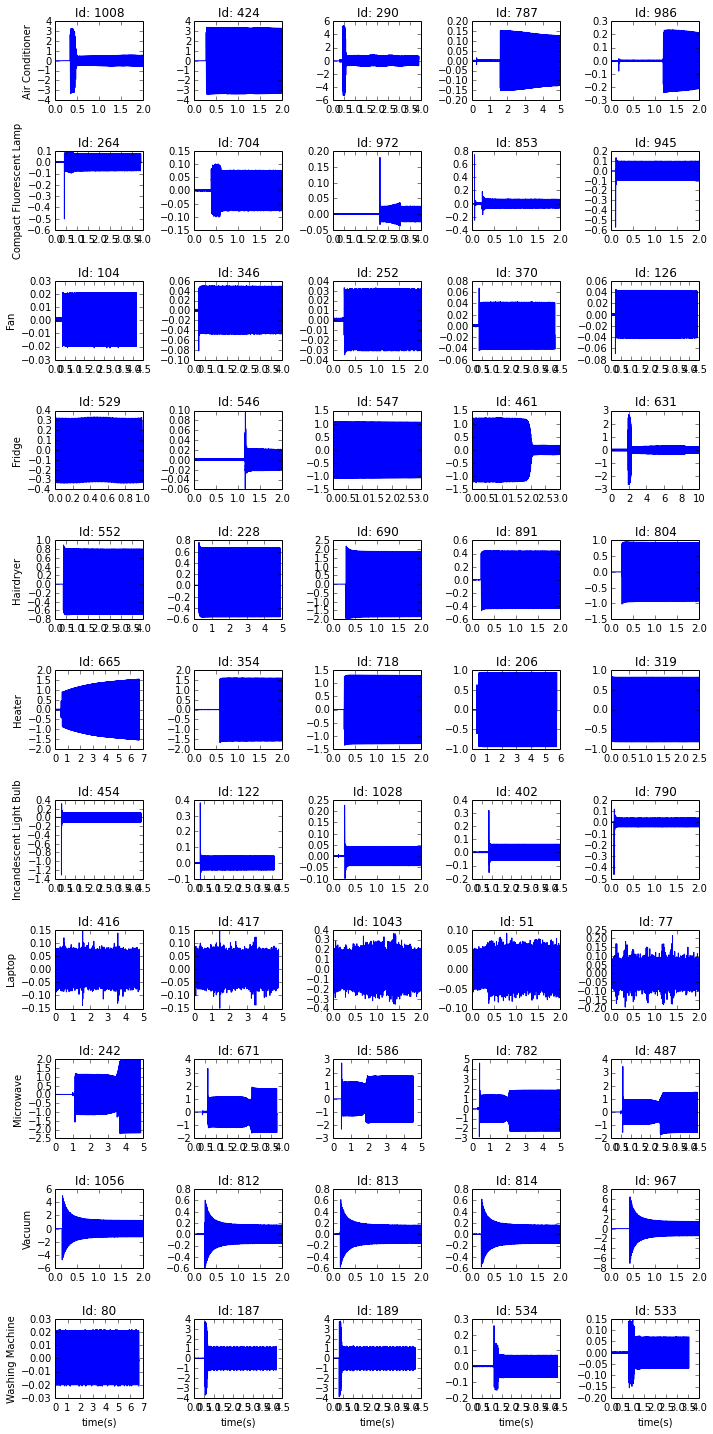

In [13]:
# plot current
fig = plt.figure(figsize=(10,20))
ids_to_draw = {}
for (ii,t) in enumerate(Unq_type):
    jj = 0
    for (k,v) in t_data[t].items():
        plt.subplot(num_type,count,ii*count+jj+1)
        plt.plot(np.linspace(1./fs,len(v['current'])/fs,num=len(v['current'])),v['current'])
        if ii==num_type-1:
            plt.xlabel('time(s)')
        if jj==0: 
            plt.ylabel(t,fontsize=10)
        plt.title('Id: '+str(k))
        jj += 1
fig.tight_layout()
plt.show()    

For a better visualization of the dataset to consider voltage, let's look at the V-I trajectory. To make it easier to be seen, we will look at the last 10000 points, which reprsents 20 periods of steady states.

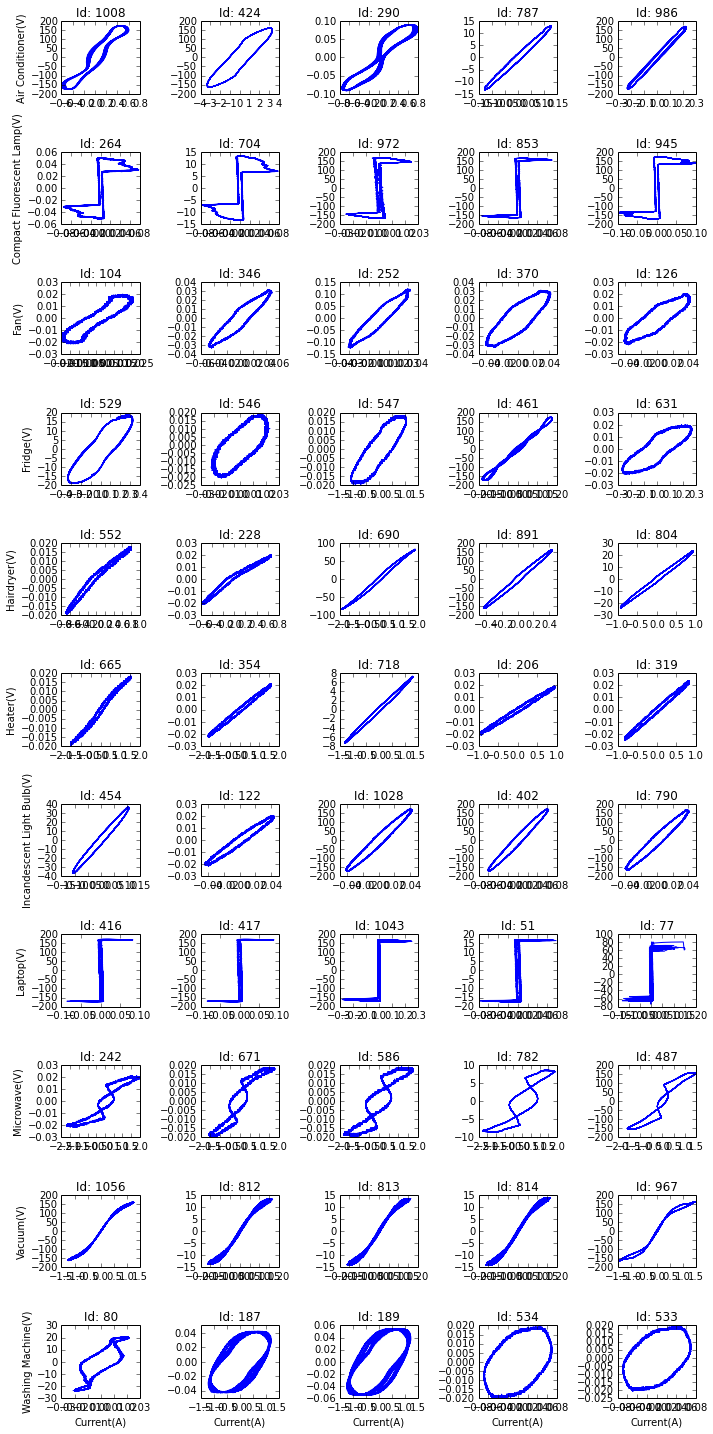

In [14]:
# plot V-I of last 10 steady state periods
fig = plt.figure(figsize=(10,20))
ids_to_draw = {}
for (ii,t) in enumerate(Unq_type):
    jj = 0
    for (k,v) in t_data[t].items():
        plt.subplot(num_type,count,ii*count+jj+1)
        plt.plot(v['current'][-1e4:],v['voltage'][-1e4:])
        if ii==num_type-1:
            plt.xlabel('Current(A)')
        if jj==0: 
            plt.ylabel(t+ '(V)',fontsize=10)
        plt.title('Id: '+str(k))
        jj += 1
fig.tight_layout()
plt.show()   

From the shapes of V-I, we can clearly see the distinct behaviours of appliances of different type. Although, we also noticed that for some appliances of the same type, they show varient patterns. 

To confirm the meta data information, we can use

In [15]:
Meta[80]

{'appliance': {'brand': '',
  'current': '',
  'manufacture_year': '',
  'model_number': '',
  'notes': '',
  'voltage': '',
  'wattage': ''},
 'header': {'collection_time': 'July, 2013',
  'notes': 'some instances are not well calibrated, meta data are not complete',
  'sampling_frequency': '30000Hz'},
 'instances': {'length': '5.97s', 'status': 'off-on'},
 'location': 'house30',
 'type': 'Washing Machine'}

to find out the associated information for this washing machine for example.